In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import os

Method#1

In [3]:
# Load your data from the DataFrame
data_files1 = pd.read_csv(r'\Users\mahin\Downloads\combined_file.csv')  # Load your combined csv file


In [5]:
# Define features and target
features = ['currentLinkStatus', 'lossTime', 'linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau']
target = ['Connected']

data_files1['currentLinkStatus'] = data_files1['currentLinkStatus'].astype('category').cat.codes

# Scaling the features
scaler = MinMaxScaler()
data_files1[features] = scaler.fit_transform(data_files1[features])

# Convert DataFrame to PyTorch tensors
X = torch.tensor(data_files1[features].values, dtype=torch.float32)
y = torch.tensor(data_files1[target].values, dtype=torch.float32)

In [7]:
# Define the Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define GAN
class GAN:
    def __init__(self, generator, discriminator, criterion, optimizer_G, optimizer_D):
        self.generator = generator
        self.discriminator = discriminator
        self.criterion = criterion
        self.optimizer_G = optimizer_G
        self.optimizer_D = optimizer_D

    def train(self, dataloader, num_epochs):
        for epoch in range(num_epochs):
            for i, (real_samples, _) in enumerate(dataloader):
                # Train Discriminator
                self.optimizer_D.zero_grad()
                real_samples = real_samples.to(device)
                real_labels = torch.ones(real_samples.size(0), 1).to(device)
                fake_labels = torch.zeros(real_samples.size(0), 1).to(device)

                # Train with real samples
                real_output = self.discriminator(real_samples)
                loss_real = self.criterion(real_output, real_labels)

                # Train with fake samples
                noise = torch.randn(real_samples.size(0), latent_size).to(device)
                fake_samples = self.generator(noise)
                fake_output = self.discriminator(fake_samples.detach())
                loss_fake = self.criterion(fake_output, fake_labels)

                # Update Discriminator
                loss_D = loss_real + loss_fake
                loss_D.backward()
                self.optimizer_D.step()

                # Train Generator
                self.optimizer_G.zero_grad()
                noise = torch.randn(real_samples.size(0), latent_size).to(device)
                fake_samples = self.generator(noise)
                output = self.discriminator(fake_samples)
                loss_G = self.criterion(output, real_labels)

                # Update Generator
                loss_G.backward()
                self.optimizer_G.step()

            # Print Losses
            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Generator Loss: {loss_G.item()}, Discriminator Loss: {loss_D.item()}")

# Parameters
input_size = len(features)
output_size = 1
latent_size = 32
batch_size = 64
num_epochs = 100
lr = 0.001

# Define DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models, optimizers, and criterion
generator = Generator(latent_size, input_size).to(device)
discriminator = Discriminator(input_size).to(device)
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Initialize GAN
gan = GAN(generator, discriminator, criterion, optimizer_G, optimizer_D)

# Train GAN
gan.train(dataloader, num_epochs)

# Generate synthetic data
with torch.no_grad():
    noise = torch.randn(len(data_files1), latent_size).to(device)
    synthetic_samples = gan.generator(noise).cpu().numpy()

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_samples, columns=features)

# Inverse scaling 
synthetic_df[features] = scaler.inverse_transform(synthetic_df[features])



Epoch [0/100], Generator Loss: 0.7083204388618469, Discriminator Loss: 1.3485021591186523
Epoch [10/100], Generator Loss: 0.9437796473503113, Discriminator Loss: 1.0594536066055298
Epoch [20/100], Generator Loss: 0.776383638381958, Discriminator Loss: 1.569658875465393
Epoch [30/100], Generator Loss: 0.5938743948936462, Discriminator Loss: 1.768643856048584
Epoch [40/100], Generator Loss: 0.7150800228118896, Discriminator Loss: 1.2978930473327637
Epoch [50/100], Generator Loss: 0.9154263138771057, Discriminator Loss: 1.245478630065918
Epoch [60/100], Generator Loss: 0.9170353412628174, Discriminator Loss: 1.229933261871338
Epoch [70/100], Generator Loss: 0.7018744945526123, Discriminator Loss: 1.4080681800842285
Epoch [80/100], Generator Loss: 0.7083266377449036, Discriminator Loss: 1.366645336151123
Epoch [90/100], Generator Loss: 0.9619309902191162, Discriminator Loss: 1.1926465034484863


In [8]:
synthetic_df.to_csv("synthetic_data.csv")

Method#2 

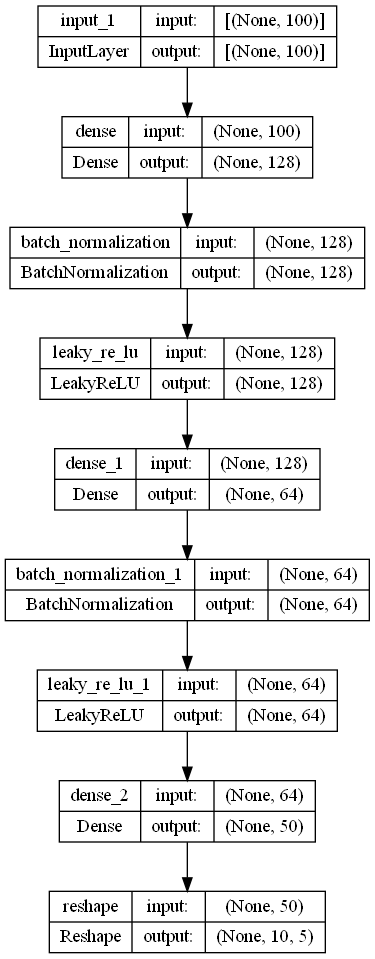

In [7]:
# This block is just to visualise the model

from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Input
from keras.models import Model
from keras.utils import plot_model

Tx = 10  # Example value, replace with your actual value
num_features = 5  # Example value, replace with your actual value

inputs = Input(shape=(100,))
x = Dense(128, use_bias=False)(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
outputs = Dense(Tx * num_features)(x)
outputs = Reshape((Tx, num_features))(outputs)

model = Model(inputs=inputs, outputs=outputs)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# Define the Generator network
def make_generator_model(Tx, num_features):
    model = keras.Sequential([
        layers.Dense(128, input_shape=(100,), use_bias=False),  # Noise input
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(Tx * num_features),
        layers.Reshape((Tx, num_features))
    ])
    return model

# Define the Discriminator network
def make_discriminator_model(Tx, num_features):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(Tx, num_features)),  # Input sequence
        layers.Flatten(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Load time series data from CSV files
path = r"\Users\mahin\Downloads\Collected_data"
scenarios = []
data_files = []

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        scenarios.append(folder)

for scenario in scenarios:
    scenario_data = []
    for file_name in os.listdir(os.path.join(path, scenario)):
        file_path = os.path.join(path, scenario, file_name)
        if file_name.endswith('.csv'):
            file_data = pd.read_csv(file_path)
            scenario_data.append(file_data)
    scenario_data = pd.concat(scenario_data, ignore_index=True)
    data_files.append(scenario_data)

# Parameters for data processing
Tx = 20
offset = 5
stride = 1
num_features = 5  # Number of features in the data

# Prepare data for training GAN
feature = []
label = []

for scenario_data in data_files:
    j = 0
    scenario_data['Connected'] = scenario_data['Connected'].apply(lambda x: 0 if x <= 0.75 else 1)
    last_label = scenario_data['Connected'].iloc[-1]

    while j + Tx <= scenario_data.shape[0] - offset:
        feature.append(scenario_data[['linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau']].iloc[j:j + Tx].values)
        current_label_idx = j + Tx + offset - 1

        if current_label_idx < scenario_data.shape[0]:
            label.append(scenario_data['Connected'].iloc[current_label_idx])
        else:
            label.append(last_label)

        j += stride

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(feature).reshape(-1, num_features)).reshape(-1, Tx, num_features)
Y = np.array(label)

# Create instances of the generator and discriminator
generator = make_generator_model(Tx, num_features)
discriminator = make_discriminator_model(Tx, num_features)

# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define optimizers
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Training loop
epochs = 11
batch_size = 64
noise_dim = 100  # Dimension of the noise input for the generator

for epoch in range(epochs):
    for i in range(len(X) // batch_size):
        real_data = X[i * batch_size : (i + 1) * batch_size]
        real_labels = Y[i * batch_size : (i + 1) * batch_size]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            generated_data = generator(noise, training=True)

            real_output = discriminator(real_data, training=True)
            fake_output = discriminator(generated_data, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print(f'Epoch {epoch + 1}, Batch {i + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

# Generate synthetic data
noise = np.random.normal(0, 1, (1000, noise_dim))
synthetic_data = generator.predict(noise)

# Inverse transform the synthetic data
synthetic_data = scaler.inverse_transform(synthetic_data.reshape(-1, num_features)).reshape(-1, Tx, num_features)


c:\Users\mahin\anaconda3\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Batch 1, Generator Loss: 1.046537160873413, Discriminator Loss: 1.5757927894592285
Epoch 1, Batch 2, Generator Loss: 1.0721616744995117, Discriminator Loss: 1.6030009984970093
Epoch 1, Batch 3, Generator Loss: 1.050204873085022, Discriminator Loss: 1.6003435850143433
Epoch 1, Batch 4, Generator Loss: 1.0244303941726685, Discriminator Loss: 1.5911539793014526
Epoch 1, Batch 5, Generator Loss: 1.0454626083374023, Discriminator Loss: 1.5842359066009521
Epoch 1, Batch 6, Generator Loss: 1.0222517251968384, Discriminator Loss: 1.575073480606079
Epoch 1, Batch 7, Generator Loss: 1.032480001449585, Discriminator Loss: 1.5817631483078003
Epoch 1, Batch 8, Generator Loss: 1.0087206363677979, Discriminator Loss: 1.5236444473266602
Epoch 1, Batch 9, Generator Loss: 1.0099802017211914, Discriminator Loss: 1.5752239227294922
Epoch 1, Batch 10, Generator Loss: 1.0275976657867432, Discriminator Loss: 1.5761126279830933
Epoch 1, Batch 11, Generator Loss: 1.0268385410308838, Discriminator Loss